# Lab1: Diabetes Data Exploration with BigQuery

### Supporting research: Diabetes

BigQuery is serverless, highly scalable, and cost-effective cloud data warehouse designed for business agility. BQ enables us to analyze petabytes of data using standard ANSI SQL at blazing-fast speeds, with zero operational overhead. BigQuery ML enables users to create and execute machine learning models within BigQuery using SQL queries. The goal is to democratize machine learning by enabling SQL practitioners to build models using their existing tools and to increase development speed by eliminating the need for data movement.

In this tutorial, you use the diabetes data available as BigQuery Public-Dataset. BigQuery provides many data set for public research.  
Comments & Feedback @astakhov
## Objectives
In this tutorial, you use:
+ BigQuery to explore ...
+ Explore diabetes dataset to understand ... distribution
+ Analyze dataset to investigate ... properties
+ Visualize and explore attributes that are most likely to contribute to development of diabetes II
https://towardsdatascience.com/diabetes-prediction-application-using-streamlit-fed6120124a5

Jupyter magics are notebook-specific shortcuts that allow you to run commands with minimal syntax. Jupyter notebooks come with many [built-in commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html). The BigQuery client library, `google-cloud-bigquery`, provides a cell magic, `%%bigquery`. The `%%bigquery` magic runs a SQL query and returns the results as a pandas `DataFrame`.

## Step 1: Explore Public Data
You can create GCP project and leverage public data set which provides free access to many datasets and free query processing. See more information [here](https://cloud.google.com/bigquery/public-data).

 


In [1]:
# Read GCP project id from env.
shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
GCP_PROJECT_ID=shell_output[0]

#GCP_PROJECT_ID='dbmigration'
print("GCP project ID:" + GCP_PROJECT_ID)

GCP project ID:covid-19-271622


In [2]:
%%bigquery --project $GCP_PROJECT_ID
SELECT * 
FROM `covid-19-271622.diabetes.diabetes`
WHERE Insulin > 0
LIMIT 10
 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,100,70,26,50,30.8,0.597,21,0
1,0,177,60,29,478,34.6,1.072,21,1
2,0,78,88,29,40,36.9,0.434,21,0
3,0,137,68,14,148,24.8,0.143,21,0
4,0,118,64,23,89,0.0,1.731,21,0
5,0,84,64,22,66,35.8,0.545,21,0
6,0,138,60,35,167,34.6,0.534,21,1
7,0,102,64,46,78,40.6,0.496,21,0
8,0,124,56,13,105,21.8,0.452,21,0
9,0,139,62,17,210,22.1,0.207,21,0


In [3]:
from google.cloud import bigquery
client = bigquery.Client()

In [4]:
sql = """
SELECT * 
FROM `covid-19-271622.diabetes.diabetes`
"""
df = client.query(sql).to_dataframe()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,125,96,0,0,22.5,0.262,21,0
1,0,100,70,26,50,30.8,0.597,21,0
2,0,102,75,23,0,0.0,0.572,21,0
3,0,113,80,16,0,31.0,0.874,21,0
4,0,177,60,29,478,34.6,1.072,21,1


In [7]:
#!pip install --user seaborn

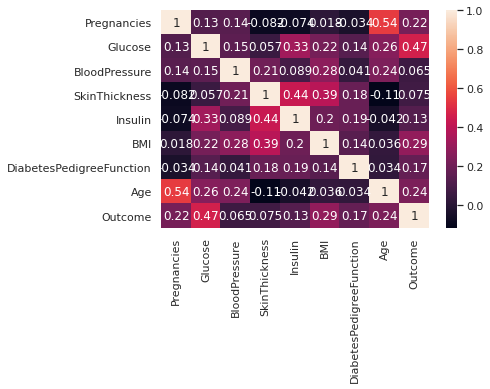

In [6]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
uniform_data = np.random.rand(10, 12)
sns.heatmap(df.corr(),annot=True)

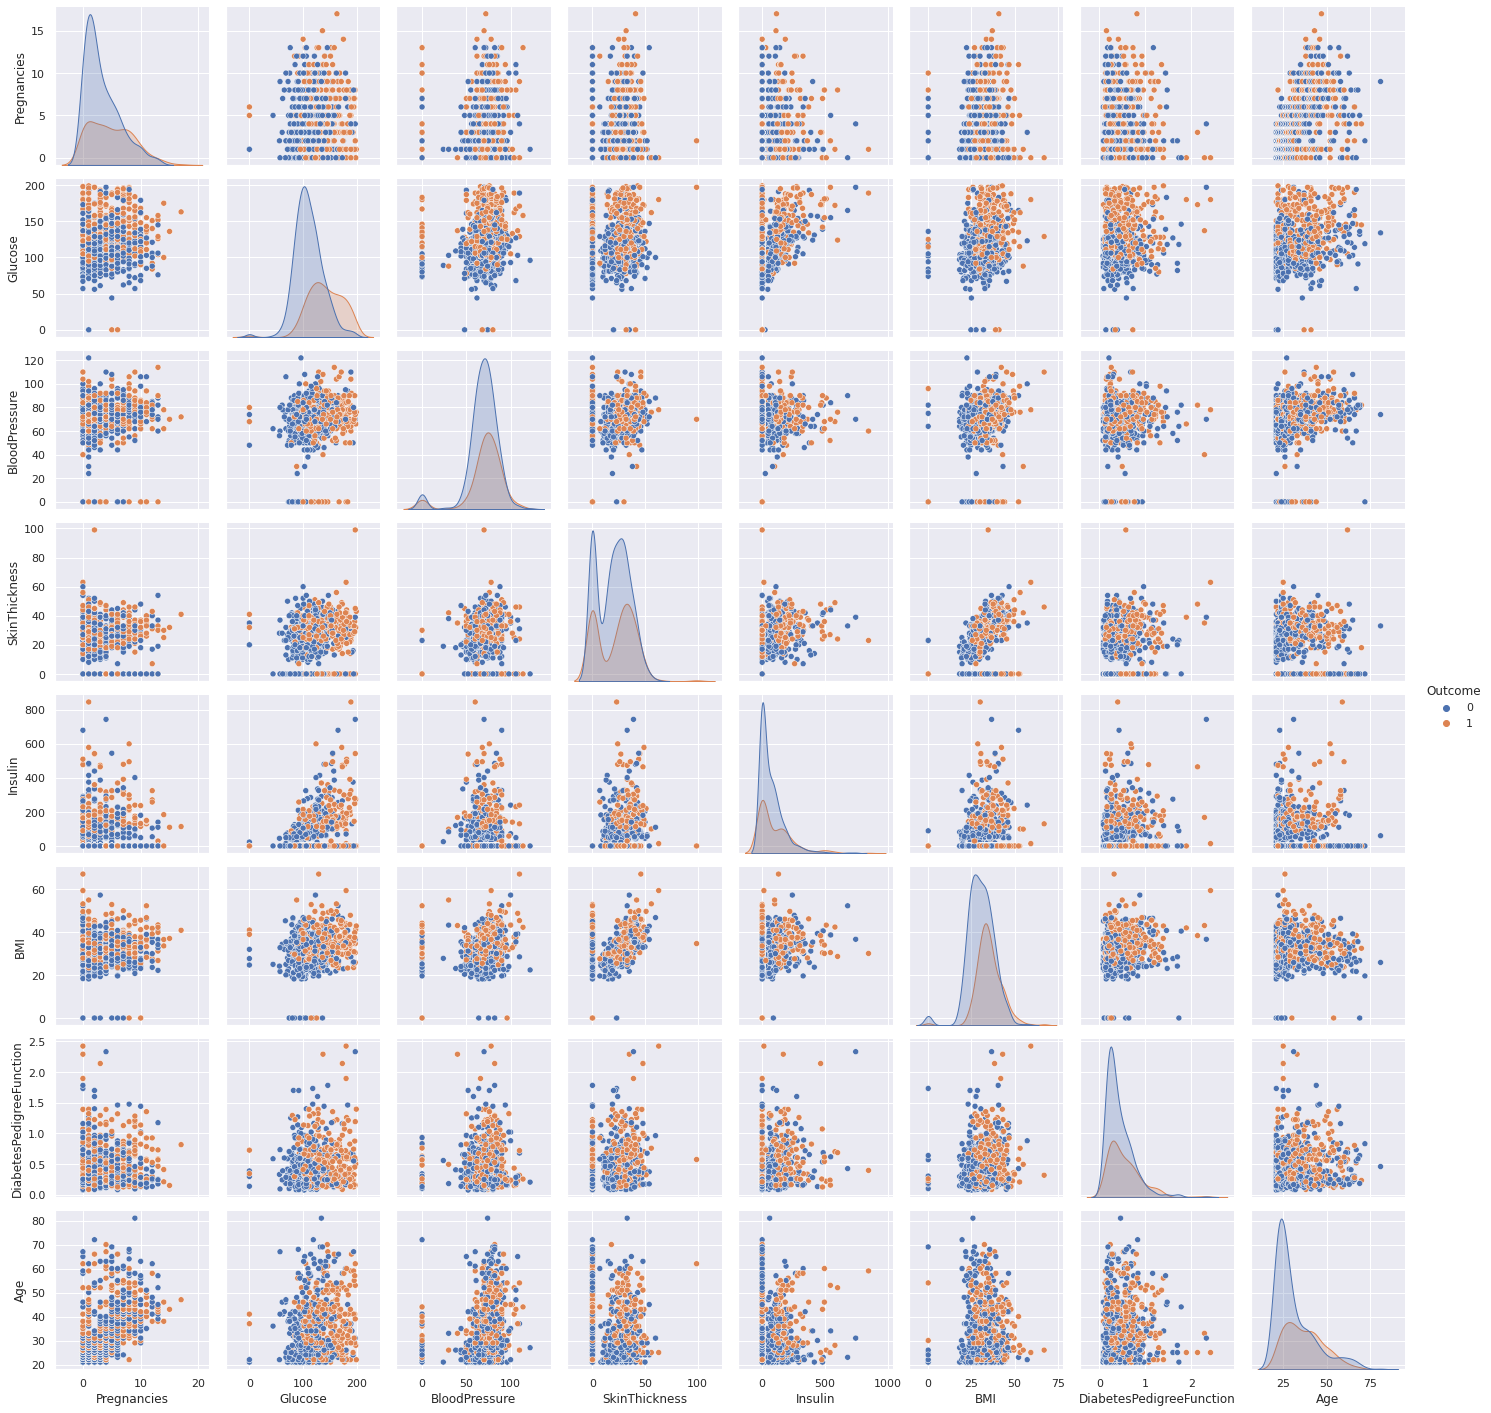

In [8]:
sns.pairplot(df,hue='Outcome')

In [12]:
#!pip install streamlit

In [14]:
!streamlit hello

Traceback (most recent call last):
  File "/opt/conda/bin/streamlit", line 5, in <module>
    from streamlit.cli import main
  File "/opt/conda/lib/python3.7/site-packages/streamlit/__init__.py", line 49, in <module>
    from streamlit.proto.RootContainer_pb2 import RootContainer
  File "/opt/conda/lib/python3.7/site-packages/streamlit/proto/RootContainer_pb2.py", line 22, in <module>
    create_key=_descriptor._internal_create_key,
AttributeError: module 'google.protobuf.descriptor' has no attribute '_internal_create_key'


Visually inspect number of epitopes by antigen name in our dataset.

In [21]:
%%bigquery epitopes --project $GCP_PROJECT_ID
SELECT
 Pregnancies,sum(Outcome) as diabetes 
FROM `covid-19-271622.diabetes.diabetes`
WHERE Outcome = 1
GROUP BY Pregnancies
ORDER BY diabetes DESC

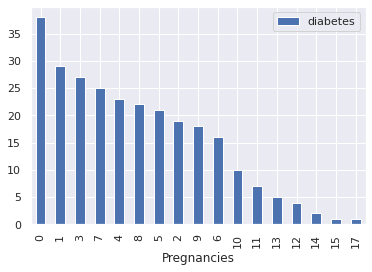

In [22]:
epitopes.plot(kind='bar', x='Pregnancies', y='diabetes');

In [5]:
# Following query shows epitope detail for those linear peptides whose parent protein
# came from Spike glycoprotein, which is our interests to investigate for possible antigen
# to protect against coronavirus


In [13]:
%%bigquery --project $GCP_PROJECT_ID
SELECT epitope_iri, Object_Type, Description, Starting_Position,
            Ending_Position, Antigen_Name,Parent_Protein, Organism_Name
FROM `bigquery-public-data.immune_epitope_db.epitope_full_v3` 
WHERE Parent_Protein = 'Spike glycoprotein'
AND organism_name like '%coronavirus%'
LIMIT 10

,epitope_iri,Object_Type,Description,Starting_Position,Ending_Position,Antigen_Name,Parent_Protein,Organism_Name


As you can see from the resulting query, we have a set of peptides generated from parent antigen protein. Now, we need to identify how these peptides bind with HLA molecule.

Following query shows HLA-peptide binding affinity information. The goal is to leverage machine learning models to predict binding affinity for many different and new peptides with HLA MHC Class-I molecules so that testing for vaccine candidates can be prioritized to accelerate solutions.


In [7]:
%%bigquery --project $GCP_PROJECT_ID
SELECT Reference_iri, Description, Allele_Name,MHC_allele_class, Assay_Group,
       Qualitative_Measure, Quantitative_measurement 
FROM `bigquery-public-data.immune_epitope_db.mhc_ligand_full`
WHERE pubmed_id = 15104671 
LIMIT 3


,Reference_iri,Description,Allele_Name,MHC_allele_class,Assay_Group,Qualitative_Measure,Quantitative_measurement
0,http://www.iedb.org/reference/329,RVDFCGKGY,HLA-A*24:02,I,qualitative binding,Negative,None
1,http://www.iedb.org/reference/329,KTTFKPNTW,HLA-B*07:02,I,qualitative binding,Negative,None
2,http://www.iedb.org/reference/329,VYANGGRGF,HLA-B*15:01,I,qualitative binding,Negative,None


In our dataset there are multiple of alleles and, for each allele we have epitope binding affinity measure. Lete inspect how epitopes and allele bindings are distributed in the dataset. This is one way to short list possible allele to consider for peptide binding research.

We will use dataframe to hold query result to build our visualization.

In [8]:
from google.cloud import bigquery
client = bigquery.Client()

In [9]:
sql = """
SELECT Qualitative_Measure, 
       Allele_Name, 
       count(1) as count 
FROM `bigquery-public-data.immune_epitope_db.mhc_ligand_full`
where organism_name like '%coronavirus%'
GROUP BY  1,2
ORDER BY 3 DESC
"""
df = client.query(sql).to_dataframe()
df.head()

,Qualitative_Measure,Allele_Name,count
0,Positive-High,HLA-DRB1*01:01,572
1,Negative,HLA-A*01:01,443
2,Negative,HLA-A*24:02,438
3,Positive-High,HLA-A*02:01,405
4,Negative,HLA-A*26:01,393


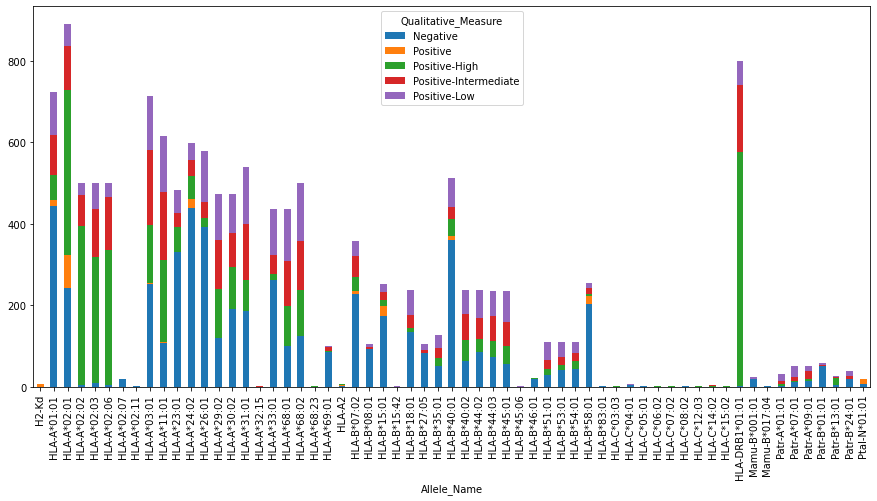

In [10]:
pivot_table = df.pivot(index='Allele_Name', columns='Qualitative_Measure', values='count')
pivot_table.plot(kind='bar', stacked=True, figsize=(15, 7));

Based on data insepction, it seems like for coronavirus data set, HLA-A-01-01, HLA-A-02-01, HLA-A-02-02, HLA-A-02-03 and HLA-A-020-06 alleles are most likely candidates for MHC-I molecules.

It is important to narrow down focus peptides and HLA binding to speed up testing on most probable vaccine candidate. Lets identify set of peptides that binds well with HLA, you can further narrow it to specific HLA as well. Following qury execution suggest that peptides with length of 9 and 10 are having better binding affinity. We should focus our research on those for now. Of course, more factors, features as well as 3D structure of aplha/beta components of HLA+Peptide bindings are useful for more complex modeling. 

In [11]:
sql = """
SELECT Qualitative_Measure, 
       length(Description) as Peptide_Length, 
       count(1) as count 
FROM `bigquery-public-data.immune_epitope_db.mhc_ligand_full`
where organism_name like '%coronavirus%'
GROUP BY  1,2
ORDER BY 3 DESC
"""
df = client.query(sql).to_dataframe()
df.head()

,Qualitative_Measure,Peptide_Length,count
0,Negative,9,3967
1,Positive-High,9,2002
2,Positive-Low,9,1273
3,Positive-Intermediate,9,1259
4,Negative,10,1196


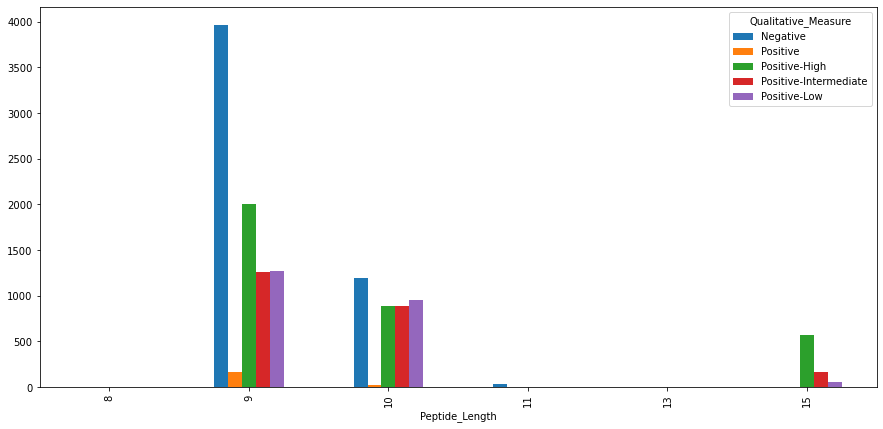

In [12]:
pivot_table = df.pivot(index='Peptide_Length', columns='Qualitative_Measure', values='count')
pivot_table.plot(kind='bar', stacked=False, figsize=(15, 7));

Chart above demonstrate that peptide with length of 9 or 10 mers are most suitable and probable candidates to investigate further for affinity modeling.

### This completes Lab1. Congratulations!